# [NTDS'17] demo 7: data exploration and visualisation
[ntds'17]: https://github.com/mdeff/ntds_2017

Michael Defferrard and Hermina Petric Maretic, based on [exercises from the 2016 edition of NTDS](https://github.com/mdeff/ntds_2016).

In [1]:
%matplotlib inline

import sys
import os
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

## 1 Organising and looking at data

In [2]:
filename = os.path.join('..', 'data', 'credit_card_defaults.csv')
data = pd.read_csv(filename, index_col = 0)
attributes = data.columns.tolist()

# Tansform from numerical to categorical variable.
data['SEX'] = data['SEX'].astype('category')
data['SEX'].cat.categories = ['MALE', 'FEMALE']
data['MARRIAGE'] = data['MARRIAGE'].astype('category')
data['MARRIAGE'].cat.categories = ['UNK', 'MARRIED', 'SINGLE', 'OTHERS']
data['EDUCATION'] = data['EDUCATION'].astype('category')
data['EDUCATION'].cat.categories = ['UNK', 'GRAD SCHOOL', 'UNIVERSITY', 'HIGH SCHOOL', 'OTHERS', 'UNK1', 'UNK2']

In [3]:
data.loc[:6, ['LIMIT', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'DEFAULT']]

,LIMIT,SEX,EDUCATION,MARRIAGE,AGE,DEFAULT
ID,,,,,,
1,20000,FEMALE,UNIVERSITY,MARRIED,24,1
2,120000,FEMALE,UNIVERSITY,SINGLE,26,1
3,90000,FEMALE,UNIVERSITY,SINGLE,34,0
4,50000,FEMALE,UNIVERSITY,MARRIED,37,0
5,50000,MALE,UNIVERSITY,MARRIED,57,0
6,50000,MALE,GRAD SCHOOL,SINGLE,37,0


In [4]:
data.iloc[:5, 4:10]

,AGE,DELAY1,DELAY2,DELAY3,DELAY4,DELAY5
ID,,,,,,
1,24,2,2,-1,-1,-2
2,26,-1,2,0,0,0
3,34,0,0,0,0,0
4,37,0,0,0,0,0
5,57,-1,0,-1,0,0


In [5]:
data.iloc[:5, 11:23]

,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6
ID,,,,,,,,,,,,
1,3913,3102,689,0,0,0,0,689,0,0,0,0
2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


Export as an [HTML table](./subset.html) for manual inspection.

In [6]:
data[:1000].to_html('subset.html')

## 2 Data Cleaning

Problems come in two flavours:

1. Missing data, i.e. unknown values.
1. Errors in data, i.e. wrong values.

The actions to be taken in each case is highly **data and problem specific**.

Example: marital status
1. According to dataset description, it should either be 1 (married), 2 (single) or 3 (others).
1. But we find some 0 (previously transformed to `UNK`).
1. Let's *assume* that 0 represents errors when collecting the data and that we should remove those clients.

In [7]:
print(data['MARRIAGE'].value_counts())
data = data[data['MARRIAGE'] != 'UNK']
data['MARRIAGE'] = data['MARRIAGE'].cat.remove_unused_categories()
print('\nWe are left with {} clients\n'.format(data.shape))
print(data['MARRIAGE'].unique())

SINGLE     15964
MARRIED    13659
OTHERS       323
UNK           54
Name: MARRIAGE, dtype: int64

We are left with (29946, 24) clients

[MARRIED, SINGLE, OTHERS]
Categories (3, object): [MARRIED, SINGLE, OTHERS]


Example: education
1. It should either be 1 (graduate school), 2 (university), 3 (high school) or 4 (others).
1. But we find some 0, 5 and 6 (previously transformed to `UNK`, `UNK1` and `UNK2`).
1. Let's *assume* these values are dubious, but do not invalidate the data and keep them as they may have some predictive power.

In [8]:
print(data['EDUCATION'].value_counts())
data.loc[data['EDUCATION'] == 'UNK1', 'EDUCATION'] = 'UNK'
data.loc[data['EDUCATION'] == 'UNK2', 'EDUCATION'] = 'UNK'
data['EDUCATION'] = data['EDUCATION'].cat.remove_unused_categories()
print(data['EDUCATION'].value_counts())

UNIVERSITY     14024
GRAD SCHOOL    10581
HIGH SCHOOL     4873
UNK1             280
OTHERS           123
UNK2              51
UNK               14
Name: EDUCATION, dtype: int64
UNIVERSITY     14024
GRAD SCHOOL    10581
HIGH SCHOOL     4873
UNK              345
OTHERS           123
Name: EDUCATION, dtype: int64


## 3 Data statistics

* Get descriptive statistics.
* Plot informative figures.
* Verify some intuitive correlations.

### 3.1 Descriptive statistics
Let's get first some descriptive statistics of our numerical variables.

In [9]:
attributes_numerical = ['LIMIT', 'AGE']
attributes_numerical.extend(attributes[11:23])
data.loc[:, attributes_numerical].describe().astype(np.int)

,LIMIT,AGE,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6
count,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946
mean,167546,35,51278,49224,47063,43306,40352,38911,5659,5926,5227,4829,4804,5220
std,129807,9,73682,71219,69393,64374,60836,59592,16552,23060,17618,15677,15290,17791
min,10000,21,-165580,-69777,-157264,-170000,-81334,-339603,0,0,0,0,0,0
25%,50000,28,3570,2988,2684,2335,1770,1261,1000,836,390,298,255,122
50%,140000,34,22400,21221,20108,19066,18121,17098,2100,2010,1800,1500,1500,1500
75%,240000,41,67263,64108,60240,54601,50244,49248,5007,5000,4511,4015,4040,4000
max,1000000,79,964511,983931,1664089,891586,927171,961664,873552,1684259,896040,621000,426529,528666


Let's plot an histogram of the ages, so that we get a better impression of who our clients are. That may even be an end goal, e.g. if your marketing team asks which customer groups to target.

Then a boxplot of the bills, which may serve as a verification of the quality of the acquired data.

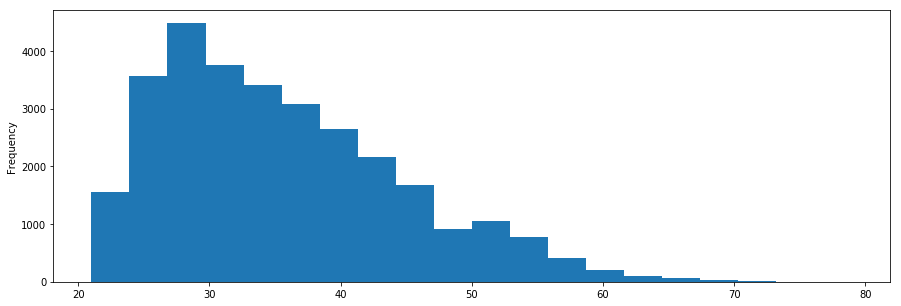

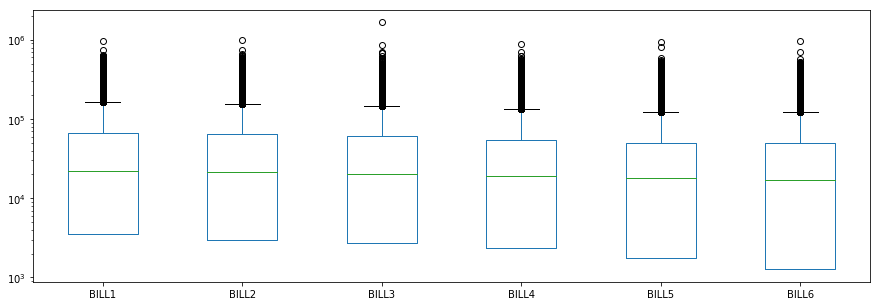

In [10]:
data.loc[:, 'AGE'].plot.hist(bins=20, figsize=(15,5))
ax = data.iloc[:, 11:17].plot.box(logy=True, figsize=(15,5))

### 3.2 Check a hypotesis

Simple **question**: which proportion of our clients default ?

In [11]:
percentage = data['DEFAULT'].value_counts()[1] / data.shape[0] * 100
print('Percentage of defaults: {:.2f}%'.format(percentage))

Percentage of defaults: 22.14%


Another **question**: who's more susceptible to default, males or females ?

In [12]:
observed = pd.crosstab(data['SEX'], data['DEFAULT'], margins=True)
observed

DEFAULT,0,1,All
SEX,,,
MALE,9003,2871,11874
FEMALE,14312,3760,18072
All,23315,6631,29946


Seems like females are better risk. Let's verify with a Chi-Squared test of independance, using [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html).

In [13]:
from scipy import stats
_, p, _, expected = stats.chi2_contingency(observed.iloc[:2,:2])
print('p-value = {:.2e}'.format(p))
print('expected values:\n{}'.format(expected))

p-value = 6.75e-12
expected values:
[[  9244.71749148   2629.28250852]
 [ 14070.28250852   4001.71749148]]


**Intuition**: people who pay late present a higher risk of defaulting. Let's verify!
Verifying some intuitions will also help you to identify mistakes. E.g. it would be suspicious if that intuition is not verified in the data: did we select the right column, or did we miss-compute a result?

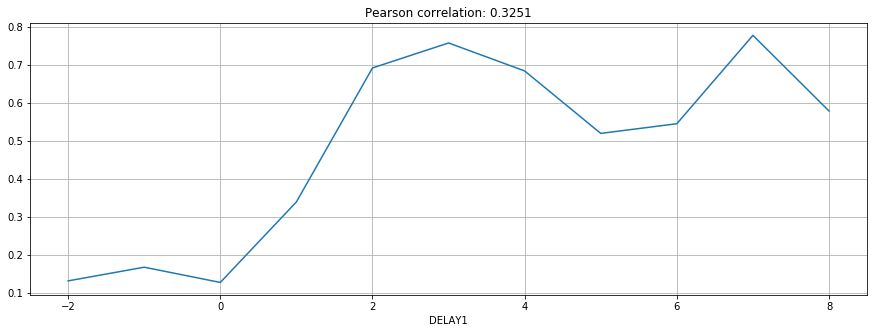

In [14]:
group = data.groupby('DELAY1').mean()
corr = data['DEFAULT'].corr(data['DELAY1'], method='pearson')
group['DEFAULT'].plot(grid=True, title='Pearson correlation: {:.4f}'.format(corr), figsize=(15,5));

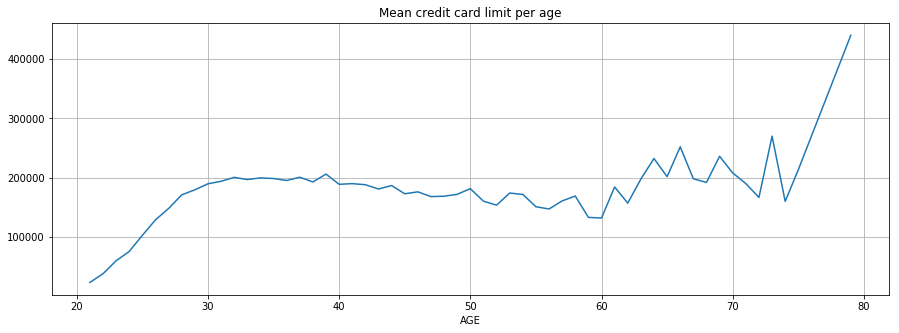

In [15]:
group = data.groupby('AGE').mean()
group['LIMIT'].plot(grid=True, title='Mean credit card limit per age', figsize=(15,5));

In [16]:
print(data['AGE'].value_counts())

29    1604
27    1475
28    1408
30    1393
26    1253
31    1213
25    1186
34    1160
32    1157
33    1145
24    1125
35    1111
36    1106
37    1035
39     953
38     943
23     930
40     868
41     821
42     793
44     699
43     670
45     613
46     569
22     560
47     499
48     466
49     451
50     409
51     338
53     324
52     304
54     247
55     208
56     177
58     122
57     122
59      83
60      67
21      67
61      56
62      44
63      31
64      31
66      25
65      24
67      16
69      15
70      10
68       5
73       4
71       3
72       3
75       3
74       1
79       1
Name: AGE, dtype: int64


### 3.3 Statistical modelling

[Statsmodels](http://statsmodels.sourceforge.net/) is similar to scikit-learn, with much stronger emphasis on parameter estimation and (statistical) testing. It is similar in spirit to other statistical packages such as [R](https://www.r-project.org), [SPSS](http://www.ibm.com/analytics/us/en/technology/spss), [SAS](http://www.sas.com/de_ch/home.html) and [Stata](http://www.stata.com). That split reflects the [two statistical modeling cultures](http://projecteuclid.org/euclid.ss/1009213726): (1) Statistics, which want to know how well a given model fits the data, and what variables "explain" or affect the outcome, and (2) Machine Learning, where the main supported task is chosing the "best" model for prediction.

In [17]:
# Back to numeric values.
data['SEX'].cat.categories = [-1, 1]
data['SEX'] = data['SEX'].astype(np.int)
data['MARRIAGE'].cat.categories = [-1, 1, 0]
data['MARRIAGE'] = data['MARRIAGE'].astype(np.int)
data['EDUCATION'].cat.categories = [-2, 2, 1, 0, -1]
data['EDUCATION'] = data['EDUCATION'].astype(np.int)

data['DEFAULT'] = data['DEFAULT'] * 2 - 1  # [0,1] --> [-1,1]

In [18]:
# Observations and targets.
X = data.values[:,:23]
y = data.values[:,23]
n, d = X.shape
print('The data is a {} with {} samples of dimensionality {}.'.format(type(X), n, d))

The data is a <class 'numpy.ndarray'> with 29946 samples of dimensionality 23.


In [19]:
import statsmodels.api as sm

# Fit the Ordinary Least Square regression model.
results = sm.OLS(y, X).fit()

# Inspect the results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     809.4
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:09:14   Log-Likelihood:                -35248.
No. Observations:               29946   AIC:                         7.054e+04
Df Residuals:                   29923   BIC:                         7.073e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.364e-07   4.35e-08     -5.428      0.0

## 4 Data visualisation
Data visualization is a key aspect of exploratory data analysis.

### 4.1 Time series

To start slowly, let's make a static line plot from some time series. Reproduce the plots below using:
1. The procedural API of [matplotlib](http://matplotlib.org), the main data visualization library for Python. Its procedural API is similar to matlab and convenient for interactive work.
2. [Pandas](http://pandas.pydata.org), which wraps matplotlib around his DataFrame format and makes many standard plots easy to code. It offers many [helpers for data visualization](http://pandas.pydata.org/pandas-docs/version/0.19.1/visualization.html).

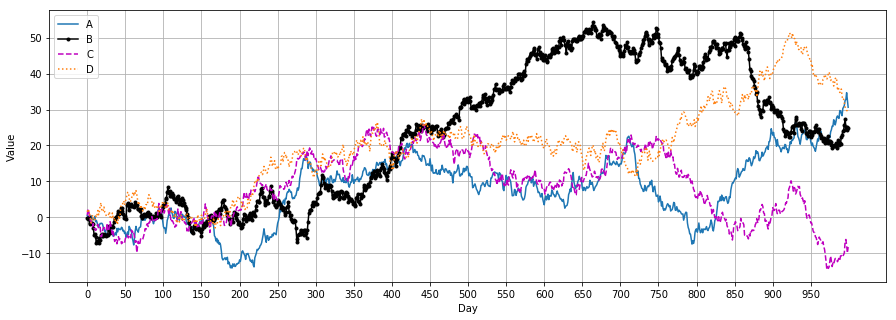

In [20]:
import matplotlib.pyplot as plt

# Random time series.
n = 1000
rs = np.random.RandomState(42)
data = rs.randn(n, 4).cumsum(axis=0)

plt.figure(figsize=(15,5))
plt.plot(data[:, 0], label='A')
plt.plot(data[:, 1], '.-k', label='B')
plt.plot(data[:, 2], '--m', label='C')
plt.plot(data[:, 3], ':', label='D')
plt.legend(loc='upper left')
plt.xticks(range(0, 1000, 50))
plt.ylabel('Value')
plt.xlabel('Day')
plt.grid()

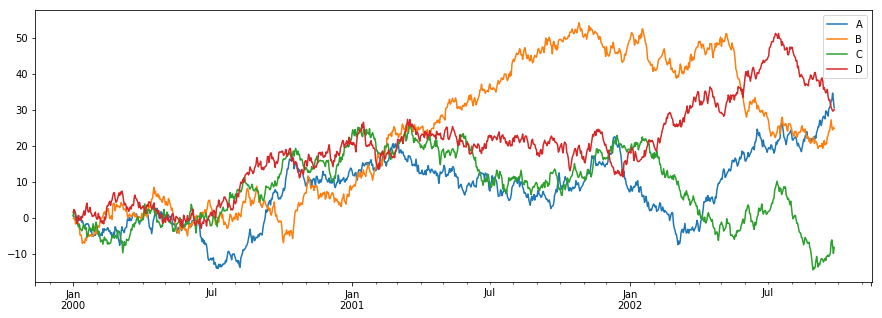

In [21]:
idx = pd.date_range('1/1/2000', periods=n)
df = pd.DataFrame(data, index=idx, columns=list('ABCD'))
df.plot(figsize=(15,5));

### 4.2 Frequency

A frequency plot is a graph that shows the pattern in a set of data by plotting how often particular values of a measure occur. They often take the form of an [histogram](https://en.wikipedia.org/wiki/Histogram) or a [box plot](https://en.wikipedia.org/wiki/Box_plot).

[Seaborn](http://seaborn.pydata.org/) is a statistical visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics. Its advantage is that you can modify the produced plots with matplotlib, so you loose nothing.

In [22]:
import seaborn as sns
df = sns.load_dataset('iris', data_home=os.path.join('..', 'data'))

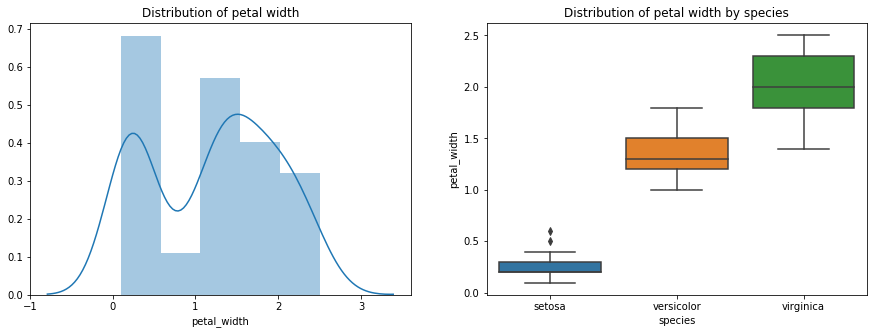

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

g = sns.distplot(df['petal_width'], kde=True, rug=False, ax=axes[0])
g.set(title='Distribution of petal width')

g = sns.boxplot('species', 'petal_width', data=df, ax=axes[1])
g.set(title='Distribution of petal width by species');

### 4.3 Correlation

[Scatter plots](https://en.wikipedia.org/wiki/Scatter_plot) are very much used to assess the correlation between 2 variables. Pair plots are then a useful way of displaying the pairwise relations between variables in a dataset.

Use the seaborn `pairplot()` function to analyze how separable is the iris dataset.

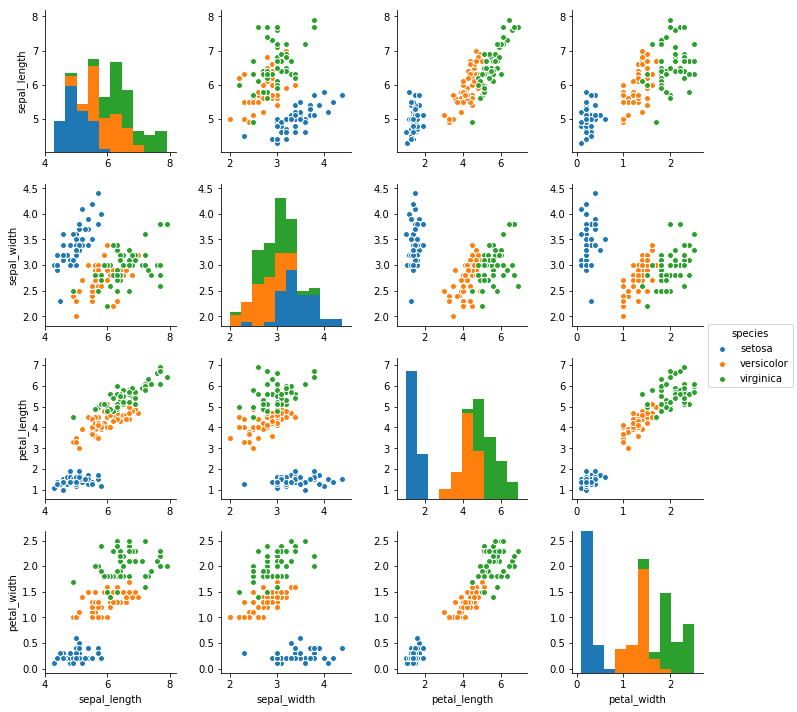

In [24]:
sns.pairplot(df, hue="species");

### 4.4 Dimensionality reduction

Humans can only comprehend up to 3 dimensions (in space, then there is e.g. color or size), so [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) is often needed to explore high dimensional datasets. Analyze how separable is the iris dataset by visualizing it in a 2D scatter plot after reduction from 4 to 2 dimensions with two popular methods:
1. The classical [principal componant analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
2. [t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

**Hints**:
* t-SNE is a stochastic method, so you may want to run it multiple times.
* The easiest way to create the scatter plot is to add columns to the pandas DataFrame, then use the Seaborn `swarmplot()`.

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [26]:
pca = PCA(n_components=2)
X = pca.fit_transform(df.values[:, :4])
df['pca1'] = X[:, 0]
df['pca2'] = X[:, 1]

tsne = TSNE(n_components=2)
X = tsne.fit_transform(df.values[:, :4])
df['tsne1'] = X[:, 0]
df['tsne2'] = X[:, 1]

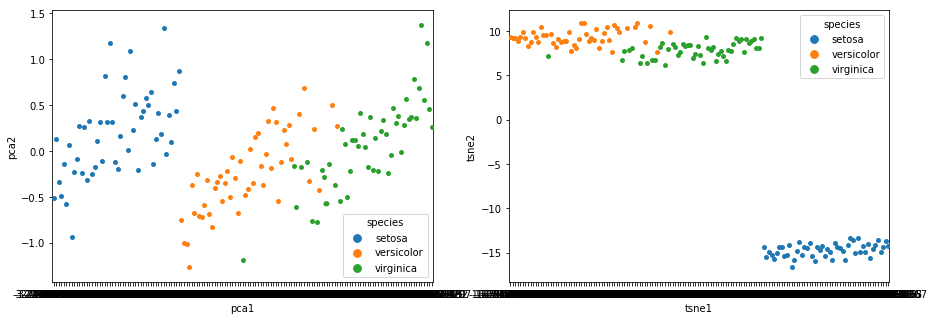

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.swarmplot(x='pca1', y='pca2', data=df, hue='species', ax=axes[0])
sns.swarmplot(x='tsne1', y='tsne2', data=df, hue='species', ax=axes[1]);

## 5 Graph visualisation
You've already worked with Networkx to make basic graph plots. Other useful resources are [Gephi](https://gephi.org/), which allows for a nicer and more artistic approach, and [Plotly](https://plot.ly/python/network-graphs/), useful for data visualisation as well as graph drawing.

In [29]:
%matplotlib notebook

import time
import networkx as nx
import scipy

<IPython.core.display.Javascript object>


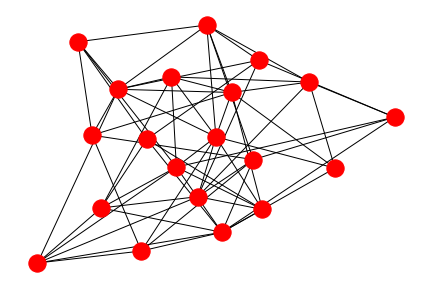

In [30]:
n = 20
T = 50
er = nx.erdos_renyi_graph(20,0.3)
er.remove_nodes_from(nx.isolates(er))  # removing isolated nodes
n = len(er)
nx.draw(er)

Time series data can also live on the nodes of our graph (e.g. temperatures in cities). Create random time series data for our graph and plot them on a graph with node size representing the signal value.

You can also experiment with different layouts for drawing the graph. The default layout positions nodes using the Fruchterman-Reingold [force-directed algorithm](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) (spring layout). Draw the graph using the spectral layout.

In [31]:
sigma_eps = 1;
epsilon = stats.norm.rvs(scale = sigma_eps, size=[n,T])  # noise

In [32]:
def draw_graph_time_series(x):
    pos = nx.spectral_layout(er)  # we have to fix the position of nodes

    l = 0
    for i in range(0,T):
        ax.clear()
        nx.draw_networkx(er, ax=ax, pos=pos, node_size=x[:,i]*100)
        ax.text(0,0,i)
        fig.canvas.draw()
        time.sleep(0.03)

<IPython.core.display.Javascript object>


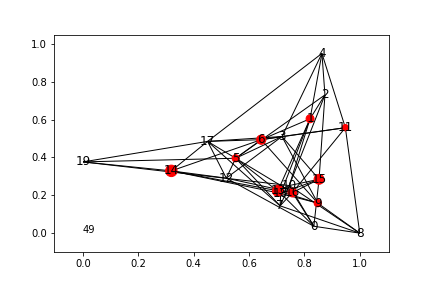

In [33]:
fig, ax = plt.subplots()
plt.ion()
fig.show()
fig.canvas.draw()

In [34]:
draw_graph_time_series(epsilon)

In the last experiment we plotted noise. Create two events on your graph at times 10 and 30. Each event should be centered in a randomly selected node and increase the signal value of that node by 50. Both events should then propagate through the graph with the heat kernel model. When an event occurs, color the source node of the event to a different color to help visualise it better. Draw the graph using the spring layout.

In [35]:
def create_x(Lapl):
    x = epsilon.copy()
    peak = np.zeros((n,2))
    for i in range(1,T):
        l = 0
        while (t[l] < i):
            peak[source[l]][l] = 1
            event = np.dot(scipy.linalg.expm((t[l]-i)*Lapl), peak[:,l])
            x[:,i] = x[:,i] + 50*event
            l += 1
            if l >= 2:
                break
    return x

t = [10, 30]
source = stats.randint.rvs(low=0, high=n, size=2)

In [36]:
Lapl = nx.normalized_laplacian_matrix(er)
Lapl = Lapl.todense()
x = create_x(Lapl)

In [37]:
def draw_graph_diffusion(x):
    pos = nx.spring_layout(er)  # we have to fix the position of nodes
    node_col = ['r'] * T
    l = 0
    for i in range(0,T):
        ax.clear()
        if l<2:
            if i == t[l]:
                node_col[source[l]] = 'b'
                l = l+1
        nx.draw_networkx(er, ax=ax, node_color = node_col, pos=pos, node_size=x[:,i]*100)
        ax.text(0,0,i)
        fig.canvas.draw()
        time.sleep(0.03)

<IPython.core.display.Javascript object>


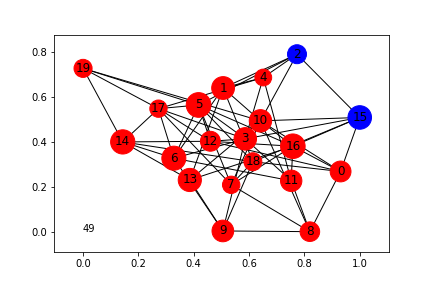

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

In [39]:
draw_graph_diffusion(x)